# Animation generation

This was the notebook used to make the animations in "geometry visualizations". It relies on manim, which is not a requirement for the docs building, and was run in its own conda environment.

In [1]:
import numpy as np
import pickle
from manim import *

config.media_width = "75%"
config.verbosity = "WARNING"

Manim Community v0.17.3

In [8]:
%%manim -ql --save_sections SquishyPlanet

class SquishyPlanet(ThreeDScene):
    def construct(self):

        ################################################################################
        # Sphere to ellipsoid
        ################################################################################

        # setup
        axes = ThreeDAxes()
        planet = Sphere(radius=1, resolution=(25, 25))
        planet.checkerboard_colors = [BLUE_D, BLUE_E]
        self.add(planet, axes)

        base_eq = MathTex(r"\frac{x^2}{r^2} + \frac{y^2}{r^2} + \frac{z^2}{r^2} = 1").scale(0.75)
        base_eq.move_to(3.5 * RIGHT + 2.5 * UP)
        self.add_fixed_in_frame_mobjects(base_eq)
        
        # start
        # theta is the lon, phi is the lat. theta=-90 gives you the x-y plane
        self.set_camera_orientation(phi=70 * DEGREES, theta=-90 * DEGREES)
        self.begin_ambient_camera_rotation(rate=0.12)  # Optional: rotate the camera
        self.play(Write(base_eq))


        # z compression
        ztext = Text("compression along z", font_size=36)
        self.add_fixed_in_frame_mobjects(ztext)
        ztext.move_to(4 * LEFT + 2.5 * UP)
        self.remove(ztext)

        arrow1 = Arrow3D(start=[0, 0, 2], end=[0, 0, 1], color=YELLOW)
        arrow2 = Arrow3D(start=[0, 0, -2], end=[0, 0, -1], color=YELLOW)
        
        self.play(FadeIn(ztext), FadeIn(arrow1), FadeIn(arrow2))
        zeq = MathTex(r"\frac{x^2}{r^2} + \frac{y^2}{r^2} + \frac{z^2}{r^2(1-f_1)^2} = 1").scale(0.75)
        zeq.move_to(3.5 * RIGHT + 2.5 * UP)
        self.add_fixed_in_frame_mobjects(zeq)
        self.remove(zeq)

        s = 0.6
        arrow1_end = Arrow3D(start=[0, 0, 2], end=[0, 0, 1*s], color=YELLOW)
        arrow2_end = Arrow3D(start=[0, 0, -2], end=[0, 0, -1*s], color=YELLOW)

        self.play(
            planet.animate.scale(np.array([1, 1, s])),
            Transform(arrow1, arrow1_end),
            Transform(arrow2, arrow2_end),
            ReplacementTransform(base_eq, zeq), run_time=4)
        
        # self.stop_ambient_camera_rotation()
        self.wait(0.5)
        self.play(
            FadeOut(arrow1),
            FadeOut(arrow2),
        )


        # y compression
        ytext = Text("compression along y", font_size=36)
        self.add_fixed_in_frame_mobjects(ytext)
        ytext.move_to(4 * LEFT + 2.5 * UP)
        self.remove(ytext)

        arrow1 = Arrow3D(start=[0, 2, 0], end=[0, 1, 0], color=YELLOW)
        arrow2 = Arrow3D(start=[0, -2, 0], end=[0, -1, 0], color=YELLOW)

        self.play(Transform(ztext, ytext), FadeIn(arrow1), FadeIn(arrow2))
        yeq = MathTex(r"\frac{x^2}{r^2} + \frac{y^2}{r^2(1-f_2)^2} + \frac{z^2}{r^2(1-f_1)^2} = 1").scale(0.75)
        yeq.move_to(3.5 * RIGHT + 2.5 * UP)
        self.add_fixed_in_frame_mobjects(yeq)
        self.remove(yeq)

        arrow1_end = Arrow3D(start=[0, 2, 0], end=[0, 1*s, 0], color=YELLOW)
        arrow2_end = Arrow3D(start=[0, -2, 0], end=[0, -1*s, 0], color=YELLOW)

        q = 0.75
        self.play(
            planet.animate.scale(np.array([1, q, 1])),
            Transform(arrow1, arrow1_end),
            Transform(arrow2, arrow2_end),
            ReplacementTransform(zeq, yeq), run_time=4)
        
        self.wait(0.5)
        self.play(
            FadeOut(arrow1),
            FadeOut(arrow2),
            FadeOut(ztext),
            FadeOut(yeq),
        )

        self.wait(1)

        self.next_section("rotations")

        ################################################################################
        # Rotate ellipsoid
        ################################################################################

        north_pole = Arrow3D(start=[0,0,s], end=[0,0,2], color=BLUE)
        self.play(FadeIn(north_pole))


        # Create a path traced by the tip of the arrow
        path = TracedPath(north_pole.get_center, stroke_color=RED, stroke_width=10)
        self.add(path)

        obliq_text = Text("obliquity rotation", font_size=36)
        self.add_fixed_in_frame_mobjects(obliq_text)
        obliq_text.move_to(4 * LEFT + 2.5 * UP)
        self.remove(obliq_text)

        # rotate
        self.play(
            Write(obliq_text),
            Rotate(planet, angle=PI/3, axis=UP, about_point=ORIGIN),
            Rotate(north_pole, angle=PI/3, axis=UP, about_point=ORIGIN), 
            run_time=2)

        self.wait(1.0)

        prec_text = Text("precession rotation", font_size=36)
        self.add_fixed_in_frame_mobjects(prec_text)
        prec_text.move_to(4 * LEFT + 2.5 * UP)
        self.remove(prec_text)

        # rotate
        self.play(
            ReplacementTransform(obliq_text, prec_text),
            Rotate(planet, angle=2*PI/3, axis=OUT, about_point=ORIGIN),
            Rotate(north_pole, angle=2*PI/3, axis=OUT, about_point=ORIGIN), 
            run_time=2)

        self.wait(1.0)
        self.stop_ambient_camera_rotation()
        self.play(
            FadeOut(prec_text),
            FadeOut(path)
        )

        ################################################################################
        # placement in orbital frame
        ################################################################################
        self.next_section("orbit")

        # move the camera to a top-down view
        phi, theta, focal_distance, gamma, distance_to_origin = self.camera.get_value_trackers()
        self.play(
            phi.animate.set_value(0),
            theta.animate.set_value(-90 * DEGREES),
        )

        self.wait(0.5)

        axes2 = ThreeDAxes(x_length=40, y_length=40, z_length=2)
        self.play(
            distance_to_origin.animate.set_value(0.45),
            Transform(axes, axes2)
        )

        self.wait(0.5)

        pole_diff = planet.get_center() - north_pole.get_center()
        r = 4
        e = 0.5
        a = r / (1 - e)
        b = a * np.sqrt(1 - e**2)
        c = np.sqrt(a**2 - b**2)
        orbit = Circle(radius=4, color=WHITE)
        ellipse = Ellipse(width=2*a, height=2*b, color=WHITE)
        ellipse.move_to(-c * RIGHT)

        self.play(
            planet.animate.move_to(r * RIGHT),
            north_pole.animate.move_to(r * RIGHT - pole_diff),
        )
        self.wait(0.5)
        self.play(Create(orbit))

        self.wait(0.5)

        self.play(
            Transform(orbit, ellipse),
            planet.animate.move_to((a - c) * RIGHT),
            north_pole.animate.move_to((a - c)* RIGHT - pole_diff),
        )

        self.wait(0.5)

        f_tracker = ValueTracker(0)
        def move_planet(mob):
            # f_tracker.increment_value(df)
            r_ = a * (1 - e**2) / (1 + e * np.cos(f_tracker.get_value()))
            mob.move_to([r_ * np.cos(f_tracker.get_value()), r_ * np.sin(f_tracker.get_value()), 0])
            return mob
        def move_pole(mob):
            r_ = a * (1 - e**2) / (1 + e * np.cos(f_tracker.get_value()))
            planet_center = [r_ * np.cos(f_tracker.get_value()), r_ * np.sin(f_tracker.get_value()), 0]
            mob.move_to(planet_center - pole_diff)
        
        planet.add_updater(move_planet)
        north_pole.add_updater(move_pole)
        
        self.play(
            f_tracker.animate.set_value(2*np.pi/3 + 0.5),
            run_time=5
        )

        self.wait(1.0)


        ################################################################################
        # rotate orbital frame
        ################################################################################
        self.next_section("orbit orientation")
        planet.clear_updaters()
        north_pole.clear_updaters()

        t = MathTex(r"\omega")
        self.add_fixed_in_frame_mobjects(t)
        t.move_to(3.5 * RIGHT + 2.5 * UP)
        self.remove(t)

        omega = 60
        self.play(
            Write(t),
            Rotate(planet, angle=omega * DEGREES, axis=OUT, about_point=ORIGIN),
            Rotate(north_pole, angle=omega * DEGREES, axis=OUT, about_point=ORIGIN),
            Rotate(orbit, angle=omega * DEGREES, axis=OUT, about_point=ORIGIN),
        )
        self.wait(1.0)

        t2 = MathTex(f"i")
        self.add_fixed_in_frame_mobjects(t2)
        t2.move_to(3.5 * RIGHT + 2.5 * UP)
        self.remove(t2)
        inc = np.pi/2 - 0.3
        self.play(
            Transform(t, t2),
            Rotate(planet, angle=inc, axis=RIGHT, about_point=ORIGIN),
            Rotate(north_pole, angle=inc, axis=RIGHT, about_point=ORIGIN),
            Rotate(orbit, angle=inc, axis=RIGHT, about_point=ORIGIN),
        )
        self.wait(1.0)

        t2 = MathTex(f"\Omega")
        self.add_fixed_in_frame_mobjects(t2)
        t2.move_to(3.5 * RIGHT + 2.5 * UP)
        self.remove(t2)
        Omega = np.pi
        self.play(
            Transform(t, t2),
            Rotate(planet, angle=Omega, axis=OUT, about_point=ORIGIN),
            Rotate(north_pole, angle=Omega, axis=OUT, about_point=ORIGIN),
            Rotate(orbit, angle=Omega, axis=OUT, about_point=ORIGIN),
        )
        self.wait(1.0)
        self.play(FadeOut(t))


        star = Sphere(radius=2.5, resolution=(20, 20), checkerboard_colors=[GOLD_C, YELLOW_D])
        star.set_fill_by_checkerboard([GOLD_C, YELLOW_D])
        star.rotate(90*DEGREES, axis=RIGHT)
        self.play(
            Create(star)
        )
        self.wait(0.5)

In [3]:
%%manim -ql TransitSetup

class TransitSetup(ThreeDScene):
    def construct(self):

        ################################################################################
        # Sphere to ellipsoid
        ################################################################################

        # setup
        axes = ThreeDAxes()
        planet = Sphere(radius=1, resolution=(25, 25))
        planet.checkerboard_colors = [BLUE_D, BLUE_E]
            # align the equator with the x-axis
        planet.rotate(-PI/2, axis=RIGHT, about_point=ORIGIN)

        # start
        # theta is the lon, phi is the lat. theta=-90 gives you the x-y plane
        self.set_camera_orientation(phi=0 * DEGREES, theta=-90 * DEGREES, 
            focal_distance=5000)

        f1 = 0.4
        s = 1-f1
        planet.scale(np.array([1, s, 1]))

        f2 = 0.25
        q = 1-f2
        planet.scale(np.array([1, 1, q]))
        # # north_pole.rotate(-PI/2, axis=RIGHT, about_point=ORIGIN)
        north_pole = Arrow3D(start=[0,s,0], end=[0,2,0], color=BLUE)


        ################################################################################
        # Rotate ellipsoid
        ################################################################################

        # obliquity rotation
        planet.rotate(-PI/3, axis=OUT, about_point=ORIGIN)
        north_pole.rotate(-PI/3, axis=OUT, about_point=ORIGIN)


        # precession rotation
        planet.rotate(-2*PI/3, axis=UP, about_point=ORIGIN)
        north_pole.rotate(-2*PI/3, axis=UP, about_point=ORIGIN)

        ################################################################################

        planet.shift(np.array([-6,0,0]))
        north_pole.shift(np.array([-6,0,0]))

        star = Sphere(radius=3, resolution=(20, 20), checkerboard_colors=[GOLD_C, YELLOW_D])
        star.set_fill_by_checkerboard([GOLD_C, YELLOW_D])
        star.rotate(90*DEGREES, axis=RIGHT)

        self.add(planet, north_pole, star)

        self.play(
            planet.animate.shift(np.array([2.1,0,0])),
            north_pole.animate.shift(np.array([2.1,0,0])),
            rate_func=linear,
            run_time=3
        )

        self.wait(1.0)

        ################################################################################
        # outlines
        star_outline = Circle(radius=3, color=YELLOW, stroke_width=10)
        planet_outline = Ellipse(
            width=0.9464789890376442*2, 
            height=0.7043099625238026*2,
            color=BLUE,
            stroke_width=10)
        planet_outline.rotate(68.05726786608072*DEGREES, axis=OUT)
        planet_outline.move_to(np.array([-3.9,0,0]))
        
        
        self.add_fixed_in_frame_mobjects(star_outline, planet_outline)
        
        self.play(
            Create(star_outline),
            Create(planet_outline)
        )

        self.wait(1.0)

        self.play(
            FadeOut(planet),
            FadeOut(north_pole),
            FadeOut(star),
        )

        self.wait(1.5)

In [6]:
angles = np.load("angles.npy")
intersections = np.load("intersections.npy")
xc = np.load("xc.npy")
times = np.load("times.npy")
with open("para.pkl", "rb") as f:
    para = pickle.load(f)

In [7]:
%%manim -ql Transit

class Transit(Scene):
    def construct(self):

        ################################################################################
        # Sphere to ellipsoid
        ################################################################################

        # setup
        star_outline = Circle(radius=3, color=YELLOW, stroke_width=10)
        planet_outline = Ellipse(
            width=0.9464789890376442*2, 
            height=0.7043099625238026*2,
            color=BLUE,
            stroke_width=10)
        planet_outline.rotate(68.05726786608072*DEGREES, axis=OUT)

        time = ValueTracker(-0.0713313)

        def move_planet(mob):
            t = time.get_value()
            new_pos = np.interp(t, times, xc)*3
            mob.move_to([new_pos, 0, 0])
            return mob

        planet_outline = move_planet(planet_outline)
        planet_outline.add_updater(move_planet)

        def move_dot(mob, index):
            t = time.get_value()
            new_pos_x = np.interp(t, times, intersections[0,:,index])
            new_pos_y = np.interp(t, times, intersections[1,:,index])
            mob.move_to([new_pos_x*3, new_pos_y*3, 0])
            return mob

        move_dot_a = lambda mob: move_dot(mob, 0)
        move_dot_b = lambda mob: move_dot(mob, 1)
        move_dot_c = lambda mob: move_dot(mob, 2)
        move_dot_d = lambda mob: move_dot(mob, 3)

        dot_a = Dot(color=RED)
        dot_b = Dot(color=RED)
        dot_c = Dot(color=RED)
        dot_d = Dot(color=RED)

        dot_a.add_updater(move_dot_a)
        dot_b.add_updater(move_dot_b)
        dot_c.add_updater(move_dot_c)
        dot_d.add_updater(move_dot_d)

        self.add(planet_outline, star_outline, dot_a, dot_b, dot_c, dot_d)

        self.play(
            time.animate.set_value(-0.05),
            run_time=2,
            rate_func=linear
        )

        self.wait(1.0)

        dot_a.clear_updaters()
        dot_b.clear_updaters()
        dot_c.clear_updaters()
        dot_d.clear_updaters()


        q = ValueTracker(0)
        def move_along_planet(mob, start_ang, end_ang):
            ang = np.interp(q.get_value(), np.array([0,1]), np.array([start_ang, end_ang]))

            cx1 = np.interp(time.get_value(), times, para["c_x1"])
            cx2 = np.interp(time.get_value(), times, para["c_x2"])
            cx3 = np.interp(time.get_value(), times, para["c_x3"])
            cy1 = np.interp(time.get_value(), times, para["c_y1"])
            cy2 = np.interp(time.get_value(), times, para["c_y2"])
            cy3 = np.interp(time.get_value(), times, para["c_y3"])

            x = cx1*np.cos(ang) + cx2*np.sin(ang) + cx3
            y = cy1*np.cos(ang) + cy2*np.sin(ang) + cy3

            mob.move_to([x*3, y*3, 0])
            return mob

        a1 = np.interp(time.get_value(), times, angles[:,0])
        a2 = np.interp(time.get_value(), times, angles[:,1])

        trace_dot = Dot(color=RED, radius=0.01)
        trace_dot.move_to(dot_a.get_center())
        self.add(trace_dot)

        trace_dot.add_updater(lambda mob: move_along_planet(mob, a1, a2))
        trace = TracedPath(trace_dot.get_center, stroke_color=RED, stroke_width=5)
        self.add(trace)

        self.play(
            q.animate.set_value(1),
            run_time=2,
            rate_func=linear
        )

        self.wait(1.0)

        w = ValueTracker(0)
        def move_along_star(mob, start_ang, end_ang):
            ang = np.interp(w.get_value(), np.array([0,1]), np.array([start_ang, end_ang]))
            ang = 2*np.pi - ang
            x = 3*np.cos(ang)
            y = 3*np.sin(ang)
            mob.move_to([x, y, 0])
            return mob

        x1, y1, _ = dot_a.get_center()
        a1b = np.arctan2(y1, x1)
        x2, y2, _ = dot_b.get_center()
        a2b = np.arctan2(y2, x2)

        if a1b < 0:
            a1b += 2*np.pi
        if a2b < 0:
            a2b += 2*np.pi

        trace_dot2 = Dot(color=RED, radius=0.01)
        trace_dot2.move_to(trace_dot.get_center())
        self.add(trace_dot2)
        trace_dot2.add_updater(lambda mob: move_along_star(mob, a1b, a2b))
        trace2 = TracedPath(trace_dot2.get_center, stroke_color=RED, stroke_width=5)
        self.add(trace2)

        self.play(
            w.animate.set_value(1),
            run_time=2,
            rate_func=linear
        )

        self.wait(1.0)

        self.play(
            FadeOut(dot_a),
            FadeOut(dot_b),
            FadeOut(dot_c),
            FadeOut(dot_d),
            FadeOut(trace_dot),
            FadeOut(trace_dot2),
            FadeOut(trace),
            FadeOut(trace2),
        )

        self.play(
            time.animate.set_value(-0.02),
            run_time=2,
            rate_func=linear
        )

        self.wait(1.0)

       
        e2 = planet_outline.copy()
        e2.set(color=RED, stroke_width=10)
        self.add(e2)
        self.play(
            Create(e2),
            rate_func=linear,
            run_time=2
        )

        self.wait(1.0)

        self.play(
            FadeOut(e2),
        )

        self.play(
            time.animate.set_value(0.0713313),
            run_time=2,
            rate_func=linear
        )

        self.wait(1.0)



In [ ]:
# the squishyplanet code for that:

# import jax

# jax.config.update("jax_enable_x64", True)
# import jax.numpy as jnp
# import matplotlib.pyplot as plt
# import numpy as np
# import pickle

# from squishyplanet import OblateSystem
# from squishyplanet.engine.polynomial_limb_darkened_transit import (
#     _single_intersection_points,
# )
# from squishyplanet.engine.parametric_ellipse import (
#     poly_to_parametric_helper,
#     cartesian_intersection_to_parametric_angle,
# )
# state = {
#     "t_peri": -0.25,
#     "times": jnp.linspace(-0.0713313, 0.0713313, 1000),
#     "a": 3.0,
#     "period": 1.0,
#     "r": 1/3,
#     "i": jnp.pi / 2,
#     "ld_u_coeffs": jnp.array([0.4, 0.26]),
#     "f1": 0.4,
#     "f2": 0.25,
#     "tidally_locked": False,
#     "obliq": -jnp.pi / 3,
#     "prec": -2 * jnp.pi / 3,
# }

# s = OblateSystem(**state)

# thetas = jnp.linspace(0, 2 * jnp.pi, 200)
# i = 0
# xs = (
#     s._para_coeffs_2d["c_x1"][i] * jnp.cos(thetas)
#     + s._para_coeffs_2d["c_x2"][i] * jnp.sin(thetas)
#     + s._para_coeffs_2d["c_x3"][i]
# )
# ys = (
#     s._para_coeffs_2d["c_y1"][i] * jnp.cos(thetas)
#     + s._para_coeffs_2d["c_y2"][i] * jnp.sin(thetas)
#     + s._para_coeffs_2d["c_y3"][i]
# )

# intersections = jax.vmap(_single_intersection_points)(
#     jnp.ones_like(s._coeffs_2d["rho_00"]) * s._coeffs_2d["rho_xx"],
#     jnp.ones_like(s._coeffs_2d["rho_00"]) * s._coeffs_2d["rho_xy"],
#     s._coeffs_2d["rho_x0"],
#     jnp.ones_like(s._coeffs_2d["rho_00"]) * s._coeffs_2d["rho_yy"],
#     s._coeffs_2d["rho_y0"],
#     s._coeffs_2d["rho_00"],
# )

# angles = jax.vmap(cartesian_intersection_to_parametric_angle)(intersections[0], intersections[1],
#     s._para_coeffs_2d["c_x1"], s._para_coeffs_2d["c_x2"], s._para_coeffs_2d["c_x3"],
#     s._para_coeffs_2d["c_y1"], s._para_coeffs_2d["c_y2"], s._para_coeffs_2d["c_y3"])

# plt.plot(s.lightcurve())
# fig, ax = plt.subplots()
# ax.plot(xs, ys, color="black")
# ax.set(aspect="equal")

# r1, r2, xc, yc, cosa, sina = poly_to_parametric_helper(**s._coeffs_2d)
# float(r1[0]), float(r2[0]), float(jnp.arctan(sina[0] / cosa[0]) * 180 / jnp.pi)

# np.save("angles.npy", np.array(angles))
# np.save("intersections.npy", np.array(intersections))
# np.save("times.npy", np.array(s.state["times"]))
# np.save("xc.npy", np.array(xc))
# with open("para.pkl", "wb") as f:
#     pickle.dump(s._para_coeffs_2d, f)

In [9]:
%%manim -ql TidalLocking

class TidalLocking(ThreeDScene):
    def construct(self):

        ################################################################################
        # Sphere to ellipsoid
        ################################################################################

        # setup
        axes = ThreeDAxes()

        # theta is the lon, phi is the lat. theta=-90 gives you the x-y plane
        self.set_camera_orientation(phi=0 * DEGREES, theta=-90 * DEGREES, 
            focal_distance=5000)

        star = Sphere(radius=3, resolution=(20, 20), checkerboard_colors=[GOLD_C, YELLOW_D])
        star.set_fill_by_checkerboard([GOLD_C, YELLOW_D])
        star.rotate(90*DEGREES, axis=RIGHT)

        f = ValueTracker(np.pi)

        planet = Sphere(radius=1, resolution=(25, 25))
        planet.checkerboard_colors = [BLUE_D, BLUE_E]
        # align the equator with the x-axis
        planet.rotate(-PI/2, axis=RIGHT, about_point=ORIGIN)

        planet.rotate(PI, axis=OUT, about_point=ORIGIN)

        f1 = 0.4
        s = 1-f1
        planet.scale(np.array([1, s, 1]))

        f2 = 0.25
        q = 1-f2
        planet.scale(np.array([1, 1, q]))

        # precession rotation
        planet.rotate(f.get_value(), axis=UP, about_point=ORIGIN)

        planet.move_to(np.array([np.cos(f.get_value()),0,np.sin(f.get_value())])*5)
    
        planet.z_index = 999
        self.add(planet, star)
        self.wait(1.0)

        self.play(
            Rotate(planet, angle=PI, axis=UP, about_point=ORIGIN),
            run_time=5,
            rate_func=linear
        )

        self.wait(1.0)

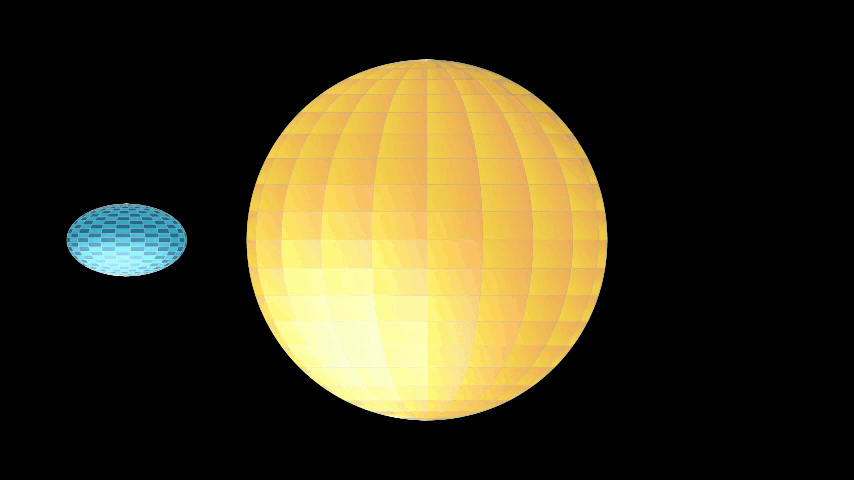

In [6]:
%%manim -ql --format gif Banner

class Banner(ThreeDScene):
    def construct(self):

        ################################################################################
        # Sphere to ellipsoid
        ################################################################################

        # setup
        axes = ThreeDAxes()

        # theta is the lon, phi is the lat. theta=-90 gives you the x-y plane
        self.set_camera_orientation(phi=0 * DEGREES, theta=-90 * DEGREES, 
            focal_distance=5000)

        star = Sphere(radius=3, resolution=(20, 20), checkerboard_colors=[GOLD_C, YELLOW_D])
        star.set_fill_by_checkerboard([GOLD_C, YELLOW_D])
        star.rotate(90*DEGREES, axis=RIGHT)

        f = ValueTracker(np.pi)

        planet = Sphere(radius=1, resolution=(25, 25))
        planet.checkerboard_colors = [BLUE_D, BLUE_E]
        # align the equator with the x-axis
        planet.rotate(-PI/2, axis=RIGHT, about_point=ORIGIN)

        planet.rotate(PI, axis=OUT, about_point=ORIGIN)

        f1 = 0.4
        s = 1-f1
        planet.scale(np.array([1, s, 1]))

        f2 = 0.25
        q = 1-f2
        planet.scale(np.array([1, 1, q]))

        # precession rotation
        planet.rotate(f.get_value(), axis=UP, about_point=ORIGIN)

        planet.move_to(np.array([np.cos(f.get_value()),0,np.sin(f.get_value())])*5)
    
        planet.z_index = 999
        self.add(planet, star)
        # self.wait(1.0)

        self.play(
            Rotate(planet, angle=PI, axis=UP, about_point=ORIGIN),
            run_time=5,
            rate_func=linear
        )
        
        planet.z_index = -999
        self.play(
            Rotate(planet, angle=PI, axis=UP, about_point=ORIGIN),
            run_time=5,
            rate_func=linear
        )
        # self.wait(1.0)